# Coding Convolution Neural Network

In this article, CNN is created using only NumPy library. Just three layers are created which are convolution (conv for short), ReLU, and max pooling. The major steps involved are as follows:

1. Reading the input image.
2. Preparing filters.
3. Conv layer: Convolving each filter with the input image.
4. ReLU layer: Applying ReLU activation function on the feature maps (output of conv layer).
5. Max Pooling layer: Applying the pooling operation on the output of ReLU layer.
6. Stacking conv, ReLU, and max pooling layers.
 

### 1. Reading input image
 
The following code reads an already existing image from the skimage Python library and converts it into gray.

In [1]:
import numpy
import skimage.data 


# Reading the image  
img = skimage.data.chelsea()  

# Converting the image into gray.  
img = skimage.color.rgb2gray(img)

### 2. Preparing filters
 
The following code prepares the filters bank for the first conv layer (l1 for short):

In [2]:
l1_filter = numpy.zeros((2,3,3))

A zero array is created according to the number of filters and the size of each filter. 2 filters of size 3x3 are created that is why the zero array is of size (2=num_filters, 3=num_rows_filter, 3=num_columns_filter). Size of the filter is selected to be 2D array without depth because the input image is gray and has no depth (i.e. 2D ). If the image is RGB with 3 channels, the filter size must be (3, 3, 3=depth).

The size of the filters bank is specified by the above zero array but not the actual values of the filters. It is possible to override such values as follows to detect vertical and horizontal edges.

In [3]:
l1_filter[0, :, :] = numpy.array([[[-1, 0, 1],   
                                   [-1, 0, 1],   
                                   [-1, 0, 1]]]) 

l1_filter[1, :, :] = numpy.array([[[1,   1,  1],   
                                   [0,   0,  0],   
                                   [-1, -1, -1]]]) 

### 3. Conv Layer
 
After preparing the filters, next is to convolve the input image by them. The next line convolves the image with the filters bank using a function called conv:

In [12]:
l1_feature_map = conv(img, l1_filter)

AttributeError: 'NoneType' object has no attribute 'shape'

Such function accepts just two arguments which are the image and the filter bank which is implemented as below.

In [5]:
def conv(img, conv_filter):
    '''
    The function starts by ensuring that the depth of each filter is equal to the number of image channels. 
    In the code below, the outer if checks if the channel and the filter have a depth. If a depth already exists, 
    then the inner if checks their inequality. If there is no match, then the script will exit.
    '''
    
    if len(img.shape) > 2 or len(conv_filter.shape) > 3:       # Check if number of image channels matches the filter depth.  
        
        if img.shape[-1] != conv_filter.shape[-1]:  
            print("Error: Number of channels in both image and filter must match.")  
            sys.exit()  
        
        '''
        Moreover, the size of the filter should be odd and filter dimensions are equal (i.e. number of rows and 
        columns are odd and equal). This is checked according to the following two ifblocks. If such conditions 
        don’t met, the script will exit.
        '''
        
        if conv_filter.shape[1] != conv_filter.shape[2]:       # Check if filter dimensions are equal.  
            print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')  
            sys.exit()  

        if conv_filter.shape[1]%2==0:                          # Check if filter diemnsions are odd.
            print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')  
            sys.exit()  

        '''
        Not satisfying any of the conditions above is a proof that the filter depth is suitable with the image and 
        convolution is ready to be applied. Convolving the image by the filter starts by initializing an array to 
        hold the outputs of convolution (i.e. feature maps) by specifying its size according to the following code:    
        '''
        
        # An empty feature map to hold the output of convolving the filter(s) with the image.  

        feature_maps = numpy.zeros((img.shape[0]-conv_filter.shape[1]+1,
                                    img.shape[1]-conv_filter.shape[1]+1,
                                    conv_filter.shape[0]))  
        
        '''
        Because there is no stride nor padding, the feature map size will be equal to 
        (img_rows-filter_rows+1, image_columns-filter_columns+1, num_filters) as above in the code. 
        Note that there is an output feature map for every filter in the bank. That is why the number of 
        filters in the filter bank (conv_filter.shape[0]) is used to specify the size as a third argument.
        '''
        
        # Convolving the image by the filter(s).  

        for filter_num in range(conv_filter.shape[0]):  
            
            '''
            The outer loop iterates over each filter in the filter bank and returns it for further steps 
            according to this line:
            '''
            
            print("Filter ", filter_num + 1)  
            curr_filter = conv_filter[filter_num, :]           # getting a filter from the bank.  
            
           
            """  
            Checking if there are mutliple channels for the single filter. 
            If so, then each channel will convolve the image. 
            The result of all convolutions are summed to return a single feature map. 
            """  
            
            if len(curr_filter.shape) > 2:  
                conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.  
                
                for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.  
                    conv_map = conv_map + conv_(img[:, :, ch_num], curr_filter[:, :, ch_num])
                
            else: # There is just a single channel in the filter.  
                conv_map = conv_(img, curr_filter)  
                feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
                
        return feature_maps # Returning all feature maps. 


You might notice that the convolution is applied by a function called conv_ which is different from the conv function. The function conv just accepts the input image and the filter bank but doesn’t apply convolution its own. It just passes each set of input-filter pairs to be convolved to the conv_ function. This is just for making the code simpler to investigate. Here is the implementation of the conv_ function:

In [4]:
def conv_(img, conv_filter):  
    filter_size = conv_filter.shape[0]  
    result = numpy.zeros((img.shape))  
    
    #Looping through the image to apply the convolution operation.  
    for r in numpy.uint16(numpy.arange(filter_size/2, img.shape[0]-filter_size/2-2)):  
        for c in numpy.uint16(numpy.arange(filter_size/2, img.shape[1]-filter_size/2-2)):  
            
            '''
            It iterates over the image and extracts regions of equal size to the filter according to this line:
            '''
            
            #Getting the current region to get multiplied with the filter.  
            curr_region = img[r:r+filter_size, c:c+filter_size]  
            
            '''
            Then it apply element-wise multiplication between the region and the filter and summing them to get 
            a single value as the output according to these lines:
            '''
            
            #Element-wise multipliplication between the current region and the filter.  
            curr_result = curr_region * conv_filter  
            conv_sum = numpy.sum(curr_result) #Summing the result of multiplication.  
            result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.  
            
    #Clipping the outliers of the result matrix.  
    final_result = result[numpy.uint16(filter_size/2):result.shape[0]-numpy.uint16(filter_size/2),   
                          numpy.uint16(filter_size/2):result.shape[1]-numpy.uint16(filter_size/2)]  
    return final_result  

After convolving each filter by the input, the feature maps are returned by the conv function. The following figure shows the feature maps returned by such conv layer.

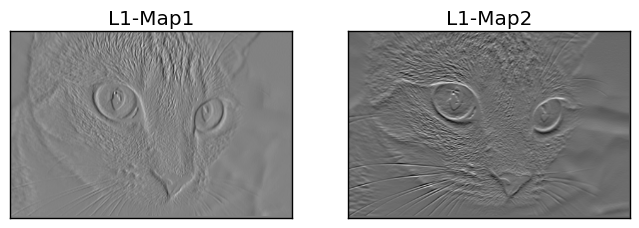

The output of such layer will be applied to the ReLU layer.

### 4. ReLU Layer
 
The ReLU layer applies the ReLU activation function over each feature map returned by the conv layer. It is called using the relu function according to the following line of code:

In [9]:
l1_feature_map_relu = relu(l1_feature_map)

AttributeError: 'NoneType' object has no attribute 'shape'

The relu function is implemented as follows:

In [8]:
def relu(feature_map):  
    #Preparing the output of the ReLU activation function.  
    relu_out = numpy.zeros(feature_map.shape)  
    for map_num in range(feature_map.shape[-1]):  
        for r in numpy.arange(0,feature_map.shape[0]):  
            for c in numpy.arange(0, feature_map.shape[1]):  
                relu_out[r, c, map_num] = numpy.max(feature_map[r, c, map_num], 0) 

It is very simple. Just loop though each element in the feature map and return the original value in the feature map if it is larger than 0. Otherwise, return 0. The outputs of the ReLU layer are shown in the next figure.

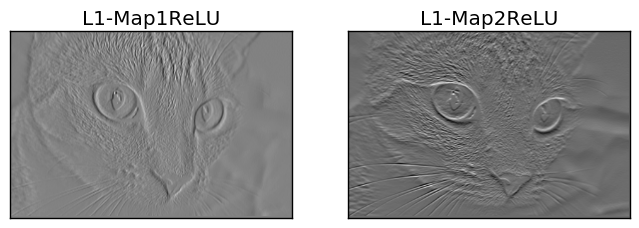

The output of the ReLU layer is applied to the max pooling layer.

### 5. Max Pooling Layer
 
The max pooling layer accepts the output of the ReLU layer and applies the max pooling operation according to the following line:

In [ ]:
l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)  

It is implemented using the pooling function as follows:

In [ ]:
def pooling(feature_map, size=2, stride=2):  
    
    #Preparing the output of the pooling operation.  
    
    '''
    The function accepts three inputs which are the output of the ReLU layer, pooling mask size, and stride. 
    It simply creates an empty array, as previous, that holds the output of such layer. The size of such array 
    is specified according to the size and stride arguments as in such line:
    '''
    
    pool_out = numpy.zeros((numpy.uint16((feature_map.shape[0]-size+1)/stride),  
                            numpy.uint16((feature_map.shape[1]-size+1)/stride),  
                            feature_map.shape[-1]))  
    
    '''
    Then it loops through the input, channel by channel according to the outer loop that uses the looping variable map_num. 
    For each channel in the input, max pooling operation is applied. According to the stride and size used, the region is 
    clipped and the max of it is returned in the output array according to this line:
    '''
    
    for map_num in range(feature_map.shape[-1]):
        r2 = 0  
        for r in numpy.arange(0,feature_map.shape[0]-size-1, stride):  
            c2 = 0  
            for c in numpy.arange(0, feature_map.shape[1]-size-1, stride):  
                pool_out[r2, c2, map_num] = numpy.max(feature_map[r:r+size,  c:c+size])  
                c2 = c2 + 1  
            r2 = r2 +1

The outputs of such pooling layer are shown in the next figure. Note that the size of the pooling layer output is smaller than its input even if they seem identical in their graphs.

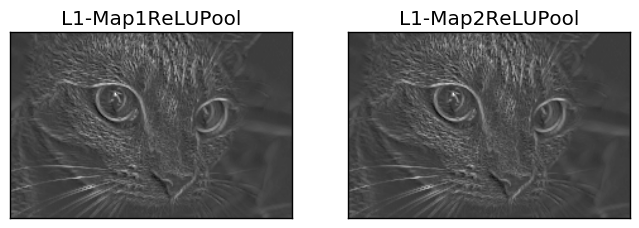

### 6. Stacking Layers
 
Up to this point, the CNN architecture with conv, ReLU, and max pooling layers is complete. There might be some other layers to be stacked in addition to the previous ones as below.

In [ ]:
# Second conv layer  
l2_filter = numpy.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])  

print("\n**Working with conv layer 2**")  
l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)  

print("\n**ReLU**")  
l2_feature_map_relu = relu(l2_feature_map)  

print("\n**Pooling**")  
l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)  

print("**End of conv layer 2**\n") 

The previous conv layer uses 3 filters with their values generated randomly. That is why there will be 3 feature maps resulted from such conv layer. This is also the same for the successive ReLU and pooling layers. Outputs of such layers are shown below.

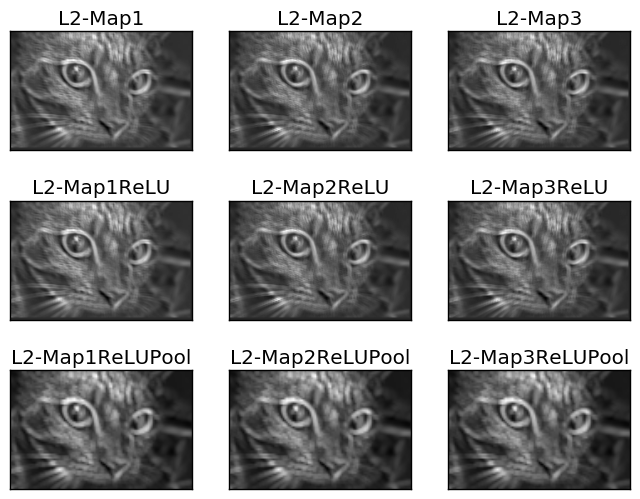

In [ ]:
# Third conv layer  
l3_filter = numpy.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])  

print("\n**Working with conv layer 3**")  
l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)  

print("\n**ReLU**")  
l3_feature_map_relu = relu(l3_feature_map)  

print("\n**Pooling**")  
l3_feature_map_relu_pool = pooling(l3_feature_map_relu, 2, 2)  

print("**End of conv layer 3**\n")  

The following figure shows the outputs of the previous layers. The previous conv layer accepts just a single filter. That is why there is only one feature map as output.

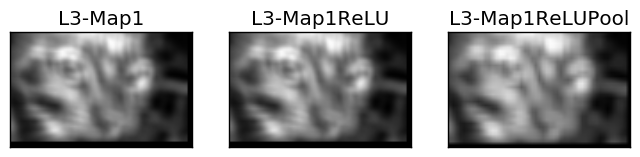

But remember, the output of each previous layer is the input to the next layer. For example, such lines accepts the previous outputs as their inputs.

1.  l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)  
2.  l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)